# Проект по анализу данных: Telco Customer Churn
**Авторы:** Тихонов Илья, Тахунов Арсен

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, norm, spearmanr, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats.mstats import zscore
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f'Датасет содержит {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()

Датасет содержит 7043 строк, 21 столбцов


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Описание датасета

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Описание каждого признака

| Признак | Описание | Тип признака | Метки значений |
|---|---|---|---|
| customerID | Уникальный идентификатор клиента | ID  | - |
| gender | Пол клиента | Категориальный | Male / Female |
| SeniorCitizen | Является ли клиент пожилым (≥ 65 лет) | Категориальный | 0 - нет, 1 - да |
| Partner | Есть ли у клиента партнёр | Категориальный | Yes / No |
| Dependents | Есть ли у клиента иждивенцы | Категориальный | Yes / No |
| tenure | Срок обслуживания в месяцах | Метрический | 0–72 (мес.) |
| PhoneService | Подключена ли телефонная связь | Категориальный | Yes / No |
| MultipleLines | Подключены ли множественные линии | Категориальный | Yes / No / No phone service |
| InternetService | Тип интернет-подключения | Категориальный | DSL / Fiber optic / No |
| OnlineSecurity | Подключена ли онлайн-безопасность | Категориальный | Yes / No / No internet service |
| OnlineBackup | Подключено ли онлайн-резервирование | Категориальный | Yes / No / No internet service |
| DeviceProtection | Подключена ли защита устройства | Категориальный | Yes / No / No internet service |
| TechSupport | Подключена ли техподдержка | Категориальный | Yes / No / No internet service |
| StreamingTV | Подключено ли потоковое ТВ | Категориальный | Yes / No / No internet service |
| StreamingMovies | Подключены ли потоковые фильмы | Категориальный | Yes / No / No internet service |
| Contract | Тип контракта | Категориальный | Month-to-month / One year / Two year |
| PaperlessBilling | Безбумажное выставление счетов | Категориальный | Yes / No |
| PaymentMethod | Способ оплаты | Категориальный | Electronic check / Mailed check / Bank transfer / Credit card |
| MonthlyCharges | Ежемесячная плата, USD | Метрический | 18.25 – 118.75 USD |
| TotalCharges | Общая сумма оплат за всё время, USD | Метрический | 18.80 – 8684.80 USD |
| Churn | Отток: покинул ли клиент компанию | Категориальный | Yes / No |

## Пункт 3. Изменение типов данных

- TotalCharges имеет тип object хотя должен быть float
- SeniorCitizen переведем из 0/1 -> Yes/No

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f'количество пустых значений TotalCharges:{df["TotalCharges"].isnull().sum()}')

df['TotalCharges'] = df['TotalCharges'].fillna(0)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

df['Churn_flag'] = df['Churn'].map({'No': 0, 'Yes': 1})

df.head(3)

количество пустых значений TotalCharges:11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_flag
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1


## Пункт 4. Расчёт нового столбца

In [6]:
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = 0
for col in service_cols:
    df['TotalServices'] += (df[col] == 'Yes').astype(int)

print(df['TotalServices'].value_counts().sort_index())
print(f'\nСреднее число сервисов: {df["TotalServices"].mean():.2f}')
df[['customerID', 'TotalServices'] + service_cols].head(10)

TotalServices
0      80
1    1701
2    1188
3     965
4     922
5     908
6     676
7     395
8     208
Name: count, dtype: int64

Среднее число сервисов: 3.36


,customerID,TotalServices,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,No phone service,No,Yes,No,No,No,No
1,5575-GNVDE,3,Yes,No,Yes,No,Yes,No,No,No
2,3668-QPYBK,3,Yes,No,Yes,Yes,No,No,No,No
3,7795-CFOCW,3,No,No phone service,Yes,No,Yes,Yes,No,No
4,9237-HQITU,1,Yes,No,No,No,No,No,No,No
5,9305-CDSKC,5,Yes,Yes,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,4,Yes,Yes,No,Yes,No,No,Yes,No
7,6713-OKOMC,1,No,No phone service,Yes,No,No,No,No,No
8,7892-POOKP,6,Yes,Yes,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,3,Yes,No,Yes,Yes,No,No,No,No


Создан новый признак TotalServices - общее количество подключённых дополнительных услуг (от 0 до 8). Он рассчитан как сумма значений «Yes» по 8 сервисным столбцам. Этот признак обобщает информацию о вовлечённости клиента и будет использован в дальнейшем анализе

## Пункт 5. Перекодировка метрического признака в категориальный

In [7]:
bins = [0, 12, 36, 72]
labels = ['Короткий', 'Средний', 'Долгий']

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

print(df['tenure_group'].value_counts().sort_index())
print('по группам')
print(df.groupby('tenure_group', observed=True)['Churn_flag'].mean())

tenure_group
Короткий    2186
Средний     1856
Долгий      3001
Name: count, dtype: int64
по группам
tenure_group
Короткий    0.474382
Средний     0.255388
Долгий      0.119294
Name: Churn_flag, dtype: float64


**Обоснование:**
- **Короткий (0–12 мес.)** - первый год обслуживания, период адаптации клиента, наибольший риск оттока.
- **Средний (13–36 мес.)** - клиент уже знаком с сервисом, но ещё высокий шанс оттока.
- **Долгий (37–72 мес.)** - лояльные клиенты с длительным стажем.


## Пункт 6. Цель и задачи исследования

### Цель исследования
Выявить ключевые факторы, влияющие на отток клиентов (Churn) телекоммуникационной компании, и построить модели, позволяющие прогнозировать отток и описывать типичные поведенческие профили клиентов.

### Задачи исследования
1. Провести разведочный анализ данных: описать структуру датасета, выявить закономерности и аномалии.
2. Исследовать взаимосвязи между характеристиками клиентов и фактом оттока с помощью сводных таблиц, статистических тестов и корреляционного анализа.
3. Построить модель линейной регрессии для предсказания ежемесячных расходов клиента на основе его характеристик.
4. Построить модель бинарной логистической регрессии для предсказания оттока клиента.
5. Провести кластерный анализ для выделения типичных профилей (сегментов) клиентов.
6. Проверить сформулированные исследовательские гипотезы и сделать содержательные выводы.

## Пункт 7. Исследовательские гипотезы

| № | Гипотеза                                                                                                 | Признаки | Метод проверки                                |
|---|----------------------------------------------------------------------------------------------------------|----------|-----------------------------------------------|
| H1 | Клиенты с помесячным контрактом  имеют более высокий уровень оттока, чем клиенты с долгосрочным контрактом. | Contract, Churn | Сводная таблица, тест хи-квадрат              |
| H2 | Более высокие ежемесячные платежи связаны с более высоким уровнем оттока.                                | MonthlyCharges, Churn | Корреляция Спирмана и логистическая регрессия |
| H3 | Пожилые клиенты имеют более высокий уровень оттока.                                                      | SeniorCitizen, Churn | Логистическая регрессия                       |
| H4 | Клиенты без подключенного интернета реже уходят.                                                            | InternetService, Churn | Логистическая регрессия                       |
| H5 | Клиенты с DSL имеют более высокий уровень оттока, чем клиенты с оптоволоконным интернетом.               | InternetService, Churn | Сводная таблица, тест хи-квадрат              |
| H6 | Чем выше общая сумма, которую клиент уже заплатил компании , тем ниже вероятность его оттока.                                                            | TotalCharges, Churn | Кластерный анализ                             |
| H7 | Срок обслуживания отрицательно коррелирует с фактом оттока.                                              | tenure, Churn | Корреляция                                    |
| H8 | Клиенты с безбумажным выставлением счетов чаще уходят.                                                   | PaperlessBilling, Churn | Сводная таблица, тест хи-квадрат              |
| H9 | Оплата электронным чеком связана с повышенным оттоком.                                                   | PaymentMethod, Churn | Сводная таблица, тест хи-квадрат              |
| H10 |  Оплата кредитной картой (автоматическая) снижает вероятность оттока по сравнению с другими методами оплаты.               | PaymentMethod, Churn | Логистическая регрессия                       |

## Пункт 8. Графики

### График 1. Уровень оттока по типу контракта

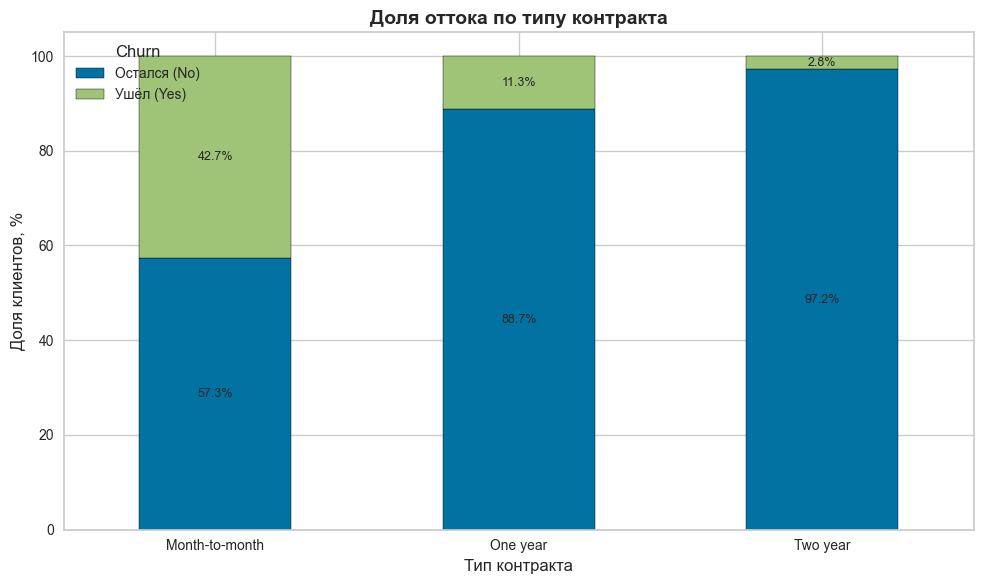

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по типу контракта', fontsize=14, fontweight='bold')
ax.set_xlabel('Тип контракта', fontsize=12)
ax.set_ylabel('Доля клиентов, %', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Уровень оттока среди клиентов с помесячным контрактом значительно выше (\~42%), чем среди клиентов с годовым (\~11%) и двухлетним (~3%) контрактами. Тип контракта - один из сильнейших предикторов оттока.

### График 2. Распределение ежемесячных платежей по группам оттока

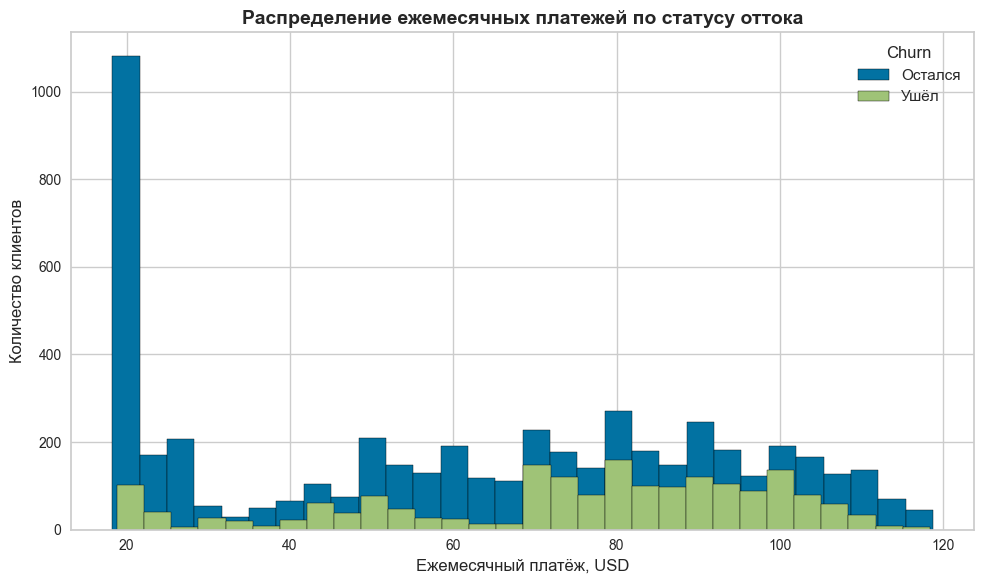

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
df[df['Churn'] == 'No']['MonthlyCharges'].hist(bins=30,label='Остался', edgecolor='black', ax=ax)
df[df['Churn'] == 'Yes']['MonthlyCharges'].hist(bins=30,label='Ушёл', edgecolor='black', ax=ax)
ax.set_title('Распределение ежемесячных платежей по статусу оттока', fontsize=14, fontweight='bold')
ax.set_xlabel('Ежемесячный платёж, USD', fontsize=12)
ax.set_ylabel('Количество клиентов', fontsize=12)
ax.legend(title='Churn', fontsize=11)
plt.tight_layout()
plt.show()

Среди оставшихся клиентов отчётливо выражена группа с низкими платежами (~20 USD), которая почти отсутствует среди ушедших. Это может указывать на то, что клиенты с базовым тарифом более лояльны.

### График 3. Boxplot: стаж обслуживания по группам оттока

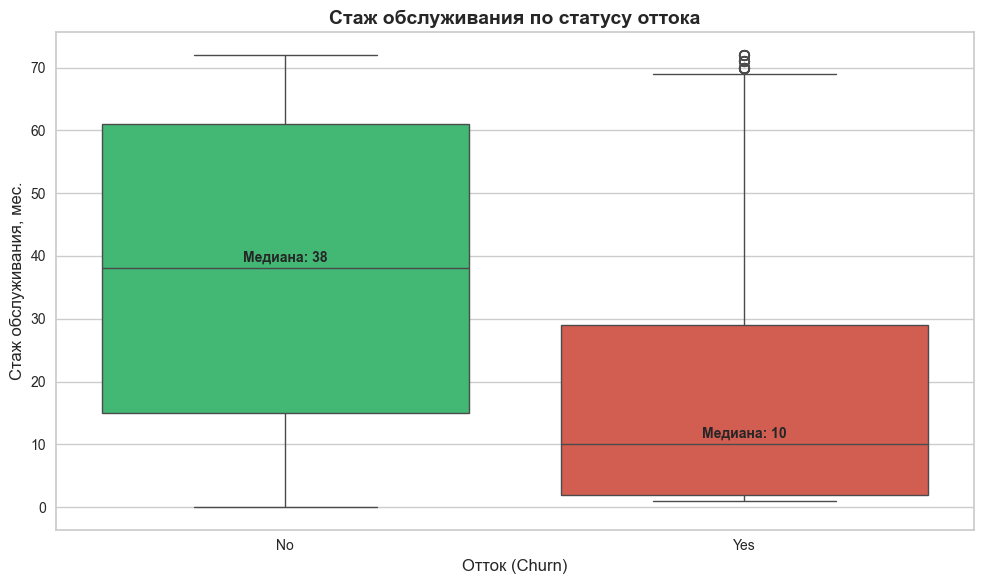

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='Churn', y='tenure', palette={'No': '#2ecc71', 'Yes': '#e74c3c'}, ax=ax)
ax.set_title('Стаж обслуживания по статусу оттока', fontsize=14, fontweight='bold')
ax.set_xlabel('Отток (Churn)', fontsize=12)
ax.set_ylabel('Стаж обслуживания, мес.', fontsize=12)
medians = df.groupby('Churn')['tenure'].median()
for i, churn_val in enumerate(['No', 'Yes']):
    ax.text(i, medians[churn_val] + 1, f'Медиана: {medians[churn_val]:.0f}', ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Ушедшие клиенты имеют значительно меньший стаж обслуживания (медиана ~10 месяцев) по сравнению с оставшимися (медиана ~38 меся). Это подтверждает, что новые клиенты находятся в зоне повышенного риска оттока

### График 4. Корреляционная тепловая карта

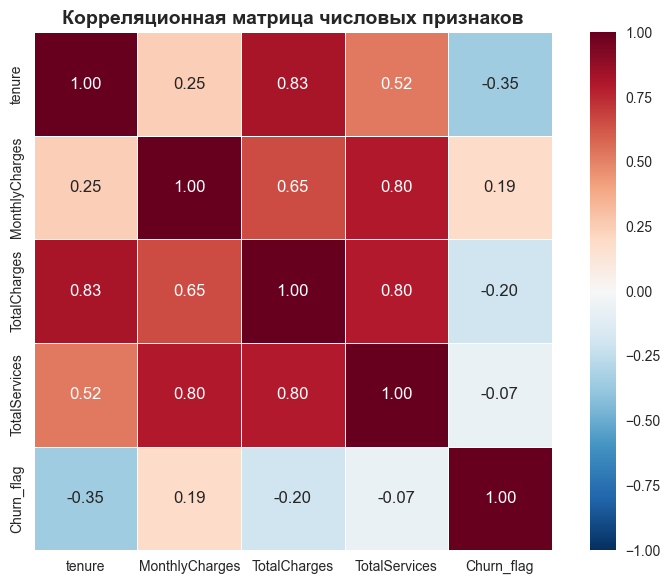

In [11]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_flag']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Корреляционная матрица числовых признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Наиболее сильная положительная корреляция наблюдается между tenure иTotalCharges (0.83), что логично - чем дольше клиент обслуживается, тем больше общая сумма. Churn_flag отрицательно коррелирует с tenure и TotalServices, и положительно - с MonthlyCharges.

### График 5. Уровень оттока по типу интернет-сервиса

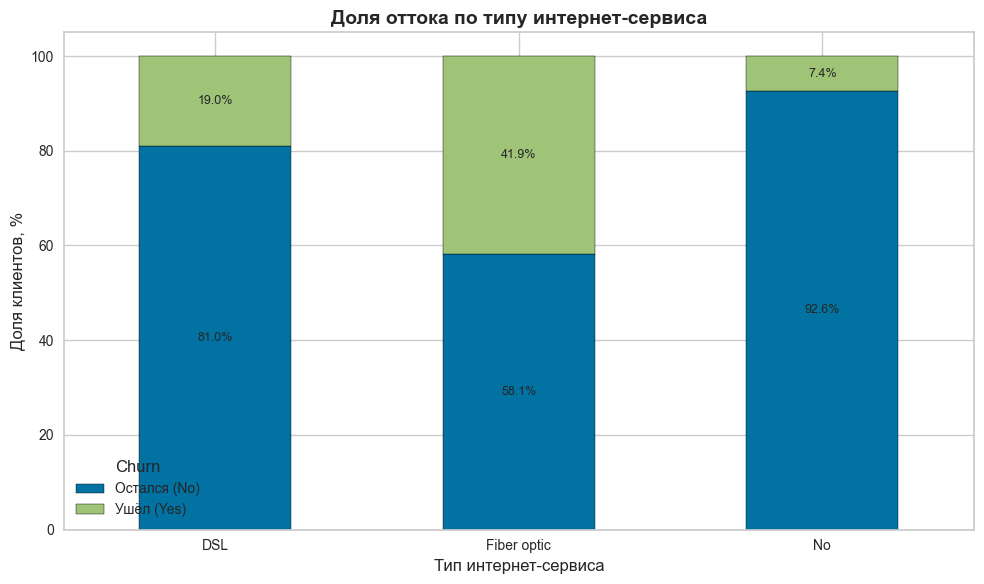

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ct_inet = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
ct_inet.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по типу интернет-сервиса', fontsize=14, fontweight='bold')
ax.set_xlabel('Тип интернет-сервиса', fontsize=12)
ax.set_ylabel('Доля клиентов, %', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Клиенты с оптоволоконным интернетом имеют самый высокий уровень оттока (42%), в то время как у клиентов с DSL он значительно ниже (19%), а среди клиентов без интернета - минимальный (7%). Возможно, это связано с более высокими ценами на оптоволокно и конкуренцией на этом сегменте.

### График 6. Уровень оттока по способу оплаты

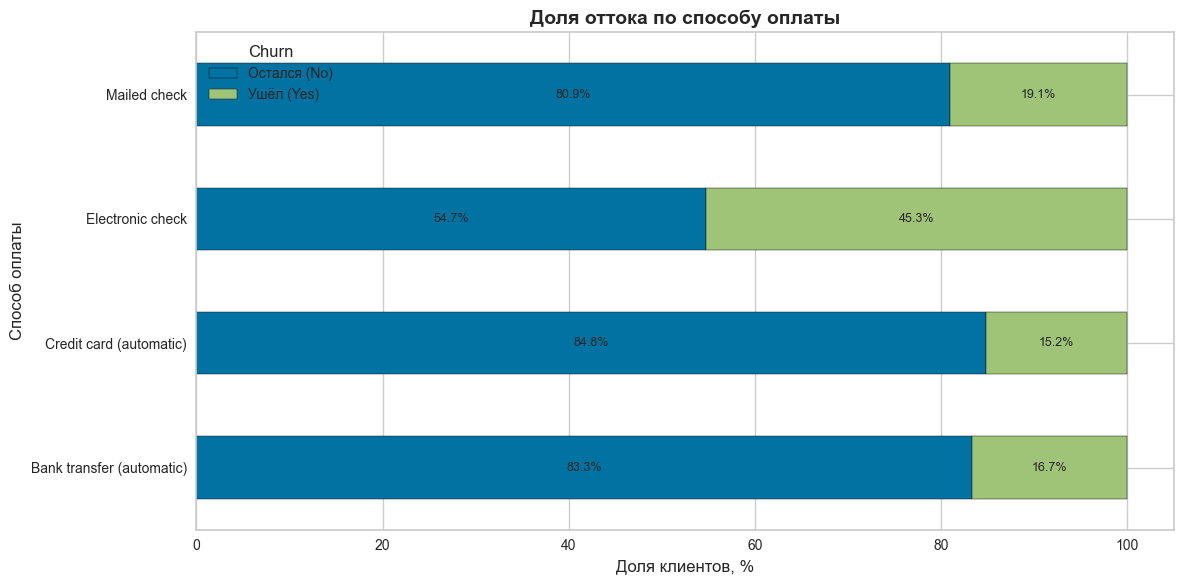

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ct_pay = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
ct_pay.plot(kind='barh', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по способу оплаты', fontsize=14, fontweight='bold')
ax.set_xlabel('Доля клиентов, %', fontsize=12)
ax.set_ylabel('Способ оплаты', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Способ оплаты электроными чеками ассоциирован с наибольшим уровнем оттока (45%). Автоматические способы оплаты (bank transfer, credit card) имеют значительно более низкий уровень оттока (15–17%). Вероятно, автоматическая оплата создаёт, снижающую вероятность ухода.

## Пункт 9. Сводные таблицы и тест хи-квадрат

### Сводная таблица 1. Контракт - Отток

In [14]:
ct1 = pd.crosstab(df['Contract'], df['Churn'], margins=True, margins_name='Итого')
print(ct1)
print()
ct1_pct = pd.crosstab(df['Contract'], df['Churn'], normalize='index').round(3) * 100
print(ct1_pct)

Churn             No   Yes  Итого
Contract                         
Month-to-month  2220  1655   3875
One year        1307   166   1473
Two year        1647    48   1695
Итого           5174  1869   7043

Churn             No   Yes
Contract                  
Month-to-month  57.3  42.7
One year        88.7  11.3
Two year        97.2   2.8


Помесячный контракт - основной источник оттока: 42.7% таких клиентов ушли. У клиентов с годовым контрактом - 11.3%, с двухлетним - лишь 2.8%. Долгосрочный контракт существенно снижает риск оттока.

H0 - переменные тип контракта и отток клиента независимы\
H1 - переменные тип контракта и отток клиента зависимы

In [15]:
ct1 = pd.crosstab(df['Contract'], df['Churn'])
a = chi2_contingency(ct1)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nx^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


x^2 = 1184.60, p-value = 5.86e-258

Минимальная ожидаемая частота: 390.9


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит отток клиента зависит от контракта

Значит H1 верна: клиенты с помесячным контрактом  имеют более высокий уровень оттока, чем клиенты с долгосрочным контрактом.

### Сводная таблица 2. Интернет-сервис - Отток

In [16]:
ct2 = pd.crosstab(df['InternetService'], df['Churn'], margins=True, margins_name='Итого')
print(ct2)
print()
ct2_pct = pd.crosstab(df['InternetService'], df['Churn'], normalize='index').round(3) * 100
print(ct2_pct)

Churn              No   Yes  Итого
InternetService                   
DSL              1962   459   2421
Fiber optic      1799  1297   3096
No               1413   113   1526
Итого            5174  1869   7043

Churn              No   Yes
InternetService            
DSL              81.0  19.0
Fiber optic      58.1  41.9
No               92.6   7.4


Оптическое волокно демонстрирует очень высокий уровень оттока (41.9%), более чем вдвое выше DSL (19.0%). Клиенты без интернета уходят редко (7.4%).

H0: Тип интернет-сервиса и отток независимы\
H1: Между типом интернет-сервиса и оттоком существует взаимосвязь

In [17]:
ct = pd.crosstab(df['InternetService'], df['Churn'])
a = chi2_contingency(ct)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nx^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


x^2 = 732.31, p-value = 9.57e-160

Минимальная ожидаемая частота: 405.0


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит связь между типом интернета и оттоком статистически значима

H5 опровергнута клиенты с оптическим волокном уходят чаще чем люди с DSL или вообще без интернета

### Сводная таблица 3. Способ оплаты - Отток

In [18]:
ct3 = pd.crosstab(df['PaymentMethod'], df['Churn'], margins=True, margins_name='Итого')
print('Абсолютные частоты:')
print(ct3)
print()
ct3_pct = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index').round(3) * 100
print('Доли по строкам (%):')
print(ct3_pct)

Абсолютные частоты:
Churn                        No   Yes  Итого
PaymentMethod                               
Bank transfer (automatic)  1286   258   1544
Credit card (automatic)    1290   232   1522
Electronic check           1294  1071   2365
Mailed check               1304   308   1612
Итого                      5174  1869   7043

Доли по строкам (%):
Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  83.3  16.7
Credit card (automatic)    84.8  15.2
Electronic check           54.7  45.3
Mailed check               80.9  19.1


Electronic check - единственный способ оплаты с долей оттока выше 40%. Все автоматические методы (bank transfer, credit card) имеют уровень оттока 15–17%. Mailed check - промежуточное положение (19%).

H0: Способ оплаты и отток независимы\
H1: Между способом оплаты и оттоком существует взаимосвязь

In [19]:
ct = pd.crosstab(df['PaymentMethod'], df['Churn'])
a = chi2_contingency(ct)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nx^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


x^2 = 648.14, p-value = 3.68e-140

Минимальная ожидаемая частота: 403.9


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит связь между способом оплаты и оттоком значима

Значит H9 подтверждена: оплата электронным чеком связана с повышенным оттоком.

## Пункт 10. Описательные статистики

### По всей выборке

In [20]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,Churn_flag,TotalServices
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.265370,3.362914
std,24.559481,30.090047,2266.794470,0.441561,2.062031
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000,1.000000
50%,29.000000,70.350000,1394.550000,0.000000,3.000000
75%,55.000000,89.850000,3786.600000,1.000000,5.000000
max,72.000000,118.750000,8684.800000,1.000000,8.000000


- tenure: среднее около 32 месяцев, медиана 29 месяцев - распределение близко к равномерному.
- MonthlyCharges: среднее около 65 USD, стандартное отклонение около 30 USD - широкий разброс тарифов.
- TotalCharges смещён вправо: у большинства клиентов суммы небольшие, но есть немного клиентов с очень большими суммами. Поэтому среднее (2279) выше медианы (1394).
- TotalServices: в среднем 3–4 услуги, распределение умеренно.

In [21]:
print('Статистики для оставшихся клиентов')
print(df[df['Churn'] == 'No'][['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].describe().round(2))
print()
print('Статистики для ушедших клиентов')
print(df[df['Churn'] == 'Yes'][['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].describe().round(2))

Статистики для оставшихся клиентов
        tenure  MonthlyCharges  TotalCharges  TotalServices
count  5174.00         5174.00       5174.00        5174.00
mean     37.57           61.27       2549.91           3.45
std      24.11           31.09       2329.95           2.16
min       0.00           18.25          0.00           0.00
25%      15.00           25.10        572.90           1.00
50%      38.00           64.43       1679.52           3.00
75%      61.00           88.40       4262.85           5.00
max      72.00          118.75       8672.45           8.00

Статистики для ушедших клиентов
        tenure  MonthlyCharges  TotalCharges  TotalServices
count  1869.00         1869.00       1869.00        1869.00
mean     17.98           74.44       1531.80           3.13
std      19.53           24.67       1890.82           1.75
min       1.00           18.85         18.85           0.00
25%       2.00           56.15        134.50           2.00
50%      10.00           79.65  

### Описательные статистики по группам оттока

- **Ушедшие** клиенты в среднем имеют значительно меньший стаж (18 месяцев vs 37 месяцев) и меньшую общую сумму платежей.
- **Ежемесячные платежи** у ушедших клиентов в среднем выше (74 USD vs 61 USD), что может указывать на неудовлетворённость соотношением цены и качества.
- **Количество сервисов** у ушедших клиентов в среднем немного меньше, что подтверждает гипотезу о роли вовлечённости.

### Описательные статистики по типу контракта

In [22]:
print(df.groupby('Contract')[['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].agg(['mean', 'median', 'std']).round(2))

               tenure               MonthlyCharges               TotalCharges  \
                 mean median    std           mean median    std         mean   
Contract                                                                        
Month-to-month  18.04   12.0  17.69          66.40  73.25  26.93      1369.25   
One year        42.04   44.0  19.04          65.05  68.75  31.84      3032.62   
Two year        56.74   64.0  18.21          60.77  64.35  34.68      3706.93   

                                 TotalServices               
                 median      std          mean median   std  
Contract                                                     
Month-to-month   679.55  1613.88          2.84    3.0  1.65  
One year        2656.70  2230.37          3.82    4.0  2.04  
Two year        3593.80  2579.52          4.17    5.0  2.52  


Клиенты с двухлетними контрактами имеют наибольший средний стаж и наибольшую общую сумму платежей. Помесячные клиенты - наибольший разброс стажа и наименьший средний стаж, что согласуется с высоким уровнем оттока в этой группе.

## Пункт 11. Корреляции между числовыми данными


=== Проверка нормальности распределения переменной: tenure ===
Statistic = 0.1110, p-value = 0.0000
H0: распределение значений переменной "tenure" статистически значимо не отличается от нормального распределения.
H1: распределение значений переменной "tenure" статистически значимо отличается от нормального распределения.
Вывод: поскольку p-value < 0.05, гипотеза H0 отвергается -> распределение не нормальное.


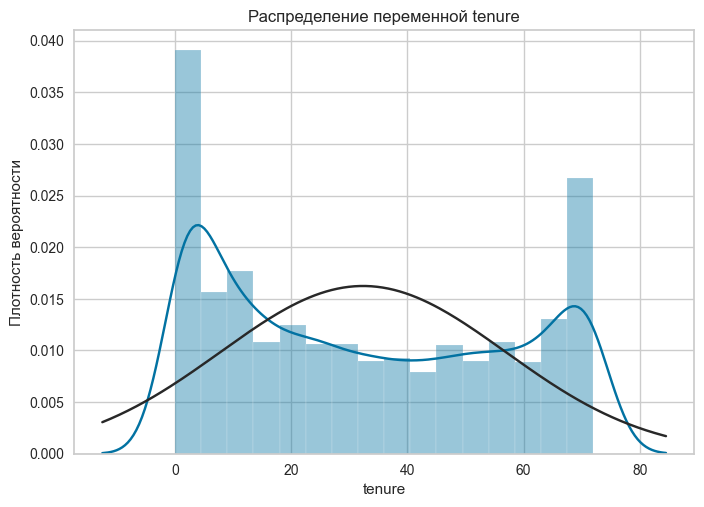


=== Проверка нормальности распределения переменной: MonthlyCharges ===
Statistic = 0.1262, p-value = 0.0000
H0: распределение значений переменной "MonthlyCharges" статистически значимо не отличается от нормального распределения.
H1: распределение значений переменной "MonthlyCharges" статистически значимо отличается от нормального распределения.
Вывод: поскольку p-value < 0.05, гипотеза H0 отвергается -> распределение не нормальное.


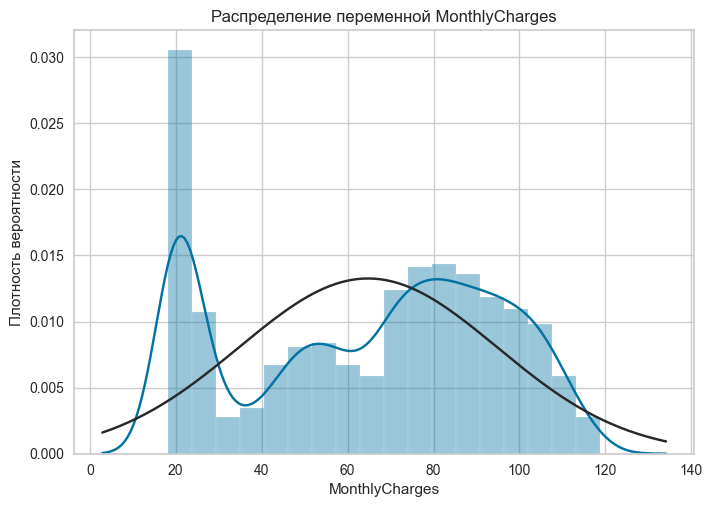


=== Проверка нормальности распределения переменной: TotalCharges ===
Statistic = 0.1577, p-value = 0.0000
H0: распределение значений переменной "TotalCharges" статистически значимо не отличается от нормального распределения.
H1: распределение значений переменной "TotalCharges" статистически значимо отличается от нормального распределения.
Вывод: поскольку p-value < 0.05, гипотеза H0 отвергается -> распределение не нормальное.


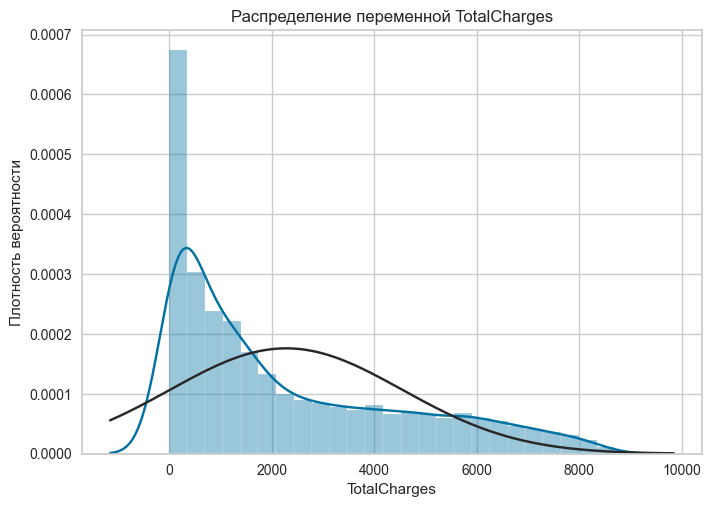


=== Проверка нормальности распределения переменной: TotalServices ===
Statistic = 0.1672, p-value = 0.0000
H0: распределение значений переменной "TotalServices" статистически значимо не отличается от нормального распределения.
H1: распределение значений переменной "TotalServices" статистически значимо отличается от нормального распределения.
Вывод: поскольку p-value < 0.05, гипотеза H0 отвергается -> распределение не нормальное.


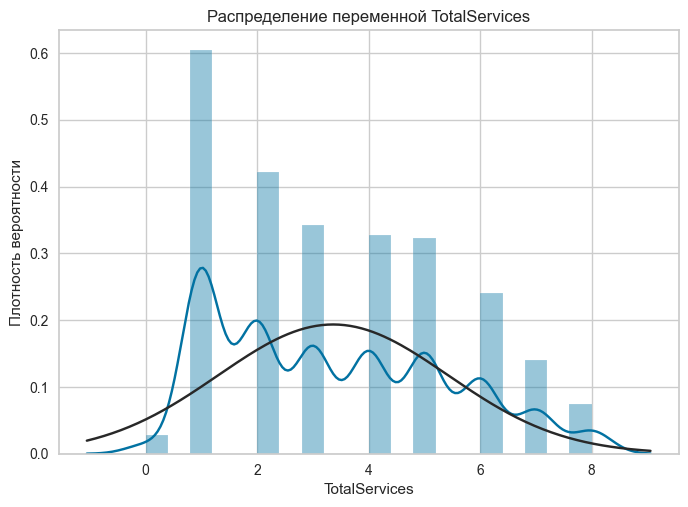

In [23]:
cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']

for col in cols:
    print(f'\n=== Проверка нормальности распределения переменной: {col} ===')
    x = df[col].dropna()

    stat, p = stats.kstest(x, 'norm', args=(x.mean(), x.std()))
    print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

    print(f"H0: распределение значений переменной \"{col}\" статистически значимо не отличается от нормального распределения.")
    print(f"H1: распределение значений переменной \"{col}\" статистически значимо отличается от нормального распределения.")

    if p < 0.05:
        print("Вывод: поскольку p-value < 0.05, гипотеза H0 отвергается -> распределение не нормальное.")
    else:
        print("Вывод: поскольку p-value > 0.05, гипотеза H1 отвергается -> распределение статистически не отличается от нормального.")

    sns.distplot(x, fit=norm)
    plt.title(f'Распределение переменной {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность вероятности')
    plt.show()


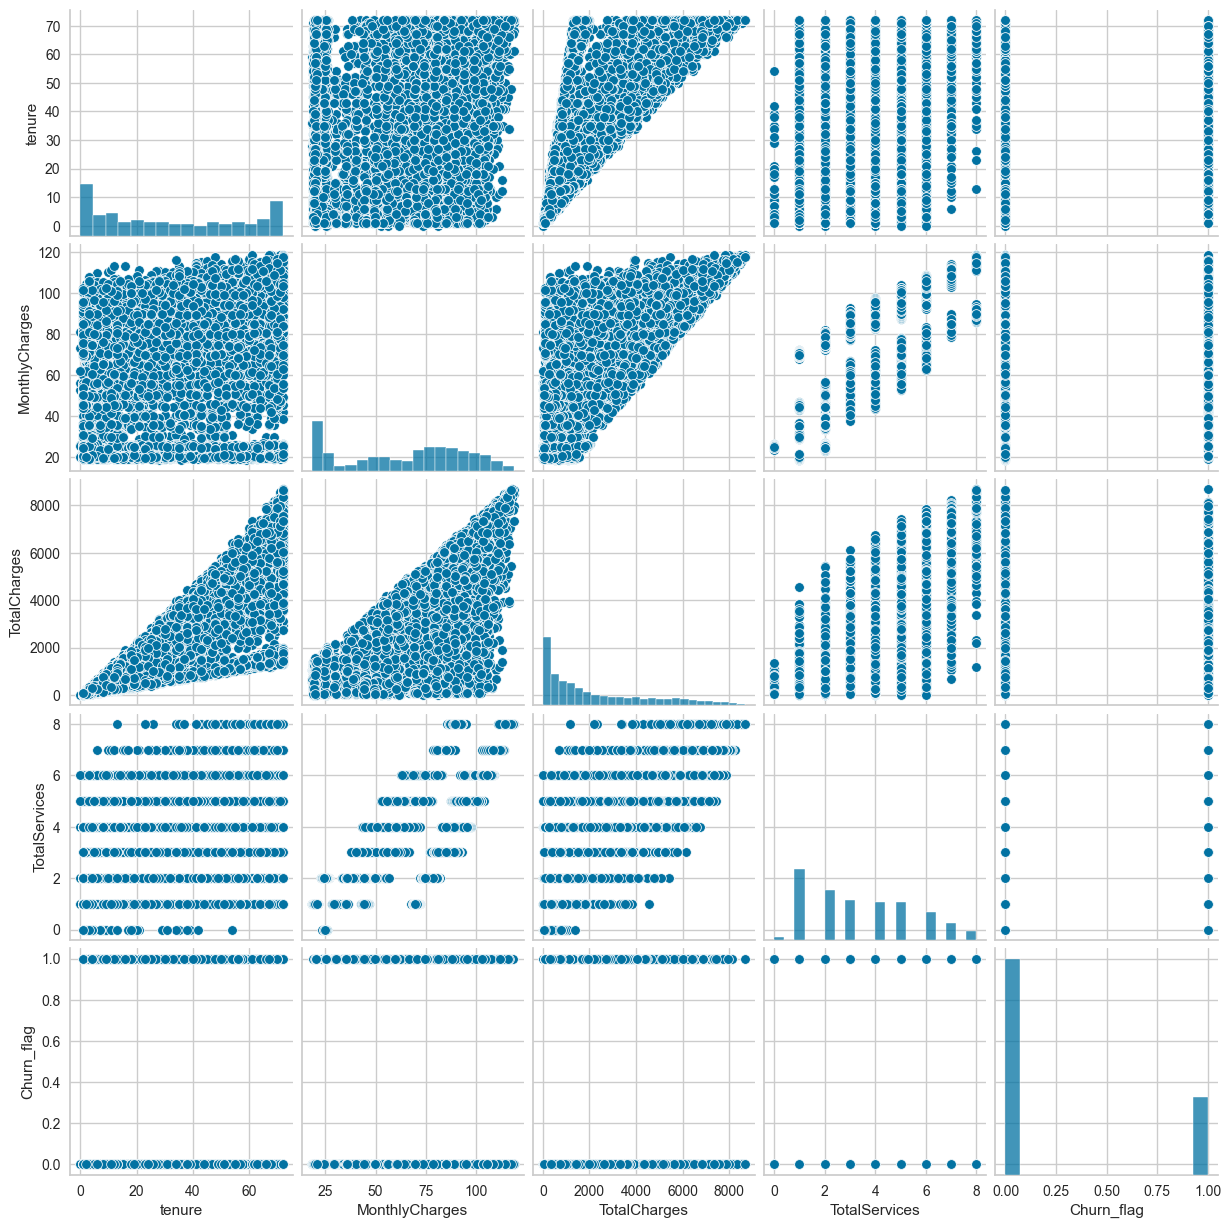

In [24]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_flag']])

Все числовые признаки **не имеют нормального распределения** (p < 0.05). Поэтому используем **корреляцию Спирмена**


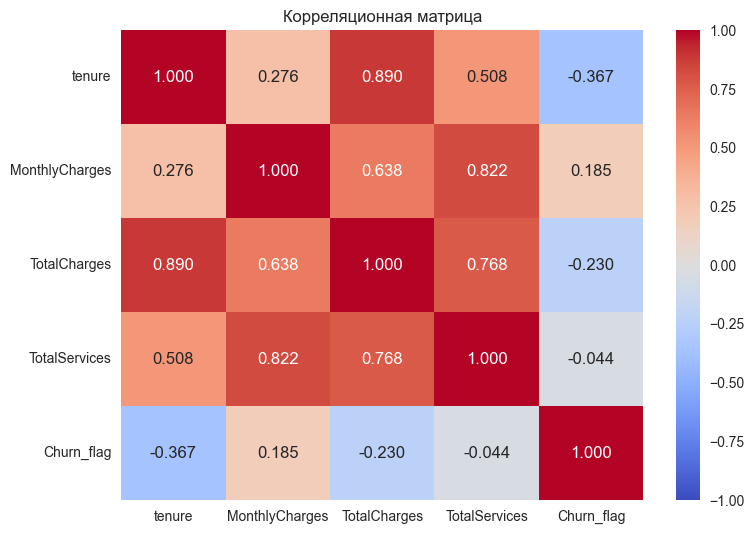

                tenure  MonthlyCharges  TotalCharges  TotalServices  \
tenure           1.000           0.276         0.890          0.508   
MonthlyCharges   0.276           1.000         0.638          0.822   
TotalCharges     0.890           0.638         1.000          0.768   
TotalServices    0.508           0.822         0.768          1.000   
Churn_flag      -0.367           0.185        -0.230         -0.044   

                Churn_flag  
tenure              -0.367  
MonthlyCharges       0.185  
TotalCharges        -0.230  
TotalServices       -0.044  
Churn_flag           1.000  


In [25]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_flag']
corr_spearman = df[numeric_cols].corr(method='spearman').round(3)

fig, ax = plt.subplots()
sns.heatmap(corr_spearman, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_title('Корреляционная матрица')
plt.tight_layout()
plt.show()

print(corr_spearman)

**Интерпретация корреляций:**

| Пара признаков | r_s | Интерпретация                                                |
|---|---|--------------------------------------------------------------|
| tenure – TotalCharges | 0.83 | Сильная положительная: длительный стаж -> большая сумма        |
| tenure – Churn_flag | −0.35 | Умеренная отрицательная: дольше обслуживается -> реже уходит   |
| MonthlyCharges – TotalServices | 0.87 | Сильная положительная: больше сервисов -> выше ежемесячная плата |
| MonthlyCharges – Churn_flag | 0.20 | Слабая положительная: дороже тариф -> чуть чаще отток        |
| TotalServices – Churn_flag | 0.05 | Практически отсутствует                                      |

Наиболее сильная линейная связь - между tenure и TotalCharges. С оттоком сильнее всего связан стаж обслуживания. Ежемесячный платёж положительно, но слабо связан с оттоком.

## Пункт 12. Модель линейной регрессии

**Зависимая переменная:** MonthlyCharges

MonthlyCharges - метрический признак с непрерывным распределением. Модель покажет, какие характеристики клиента и подключённых услуг определяют размер платежа.

**Предикторы:** tenure, SeniorCitizen (дамми), Partner (дамми), InternetService (дамми), Contract (дамми), PhoneService (дамми), OnlineSecurity (дамми), StreamingTV (дамми).

In [26]:
df_reg = df.copy()
senior_d = pd.get_dummies(df_reg['SeniorCitizen'], prefix='Senior', dtype=int)
partner_d = pd.get_dummies(df_reg['Partner'], prefix='Partner', dtype=int)
inet_d = pd.get_dummies(df_reg['InternetService'], prefix='Inet', dtype=int)
contract_d = pd.get_dummies(df_reg['Contract'], prefix='Contract', dtype=int)
phone_d = pd.get_dummies(df_reg['PhoneService'], prefix='Phone', dtype=int)
security_d = pd.get_dummies(df_reg['OnlineSecurity'], prefix='Security', dtype=int)
streaming_d = pd.get_dummies(df_reg['StreamingTV'], prefix='StreamTV', dtype=int)

X_cols = ['tenure', 'Senior_Yes', 'Partner_Yes',
          'Inet_Fiber optic', 'Inet_No',
          'Contract_One year', 'Contract_Two year',
          'Phone_Yes',
          'Security_Yes', 'Security_No internet service',
          'StreamTV_Yes', 'StreamTV_No internet service']

df_reg = pd.concat([df_reg, senior_d, partner_d, inet_d, contract_d, phone_d, security_d, streaming_d], axis=1)

X = df_reg[X_cols]

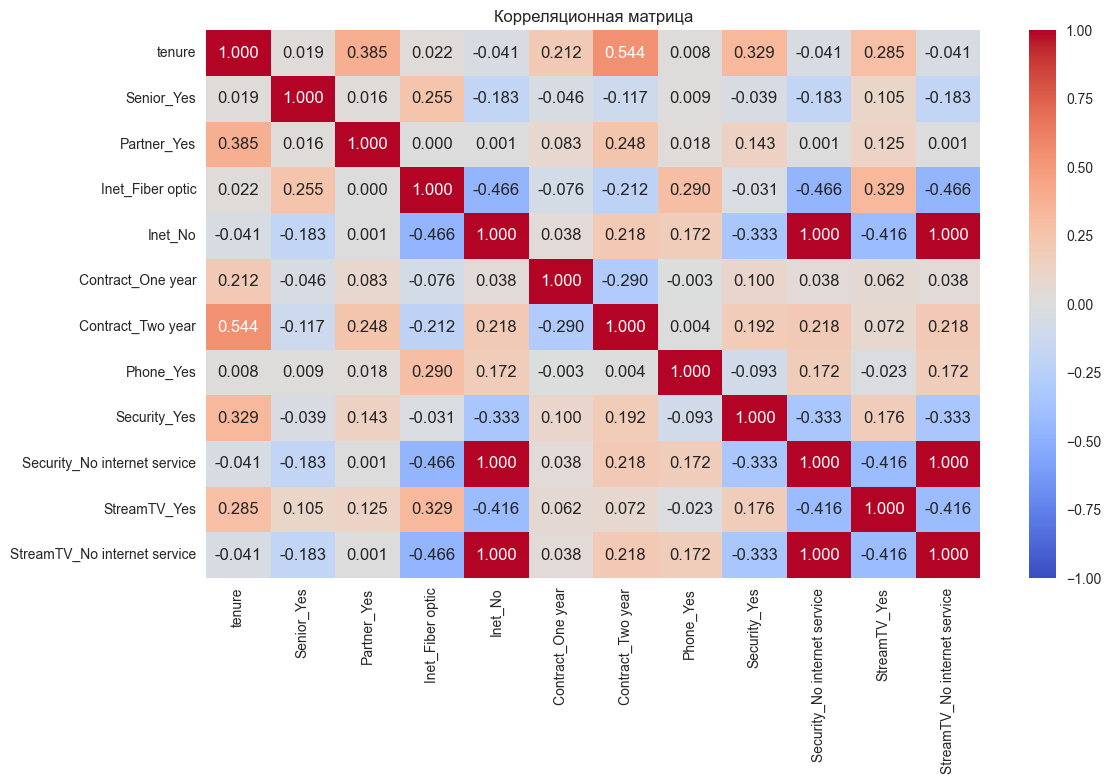

In [27]:
corr = X.corr(method='spearman', numeric_only=True).round(3)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_title('Корреляционная матрица')
plt.tight_layout()
plt.show()


Смотрим на корреляции переменных. Между дамми переменными: (Security_No internet service, Inet_no), (Security_No internet service, StreamTV_No internet service), (StreamTV_No internet service, Inet_No) - прямая связь, поэтому следует оставить одну из них, чтобы избежать мультиколлиниарности

In [28]:
X = X.drop(columns=['Security_No internet service', 'StreamTV_No internet service'])

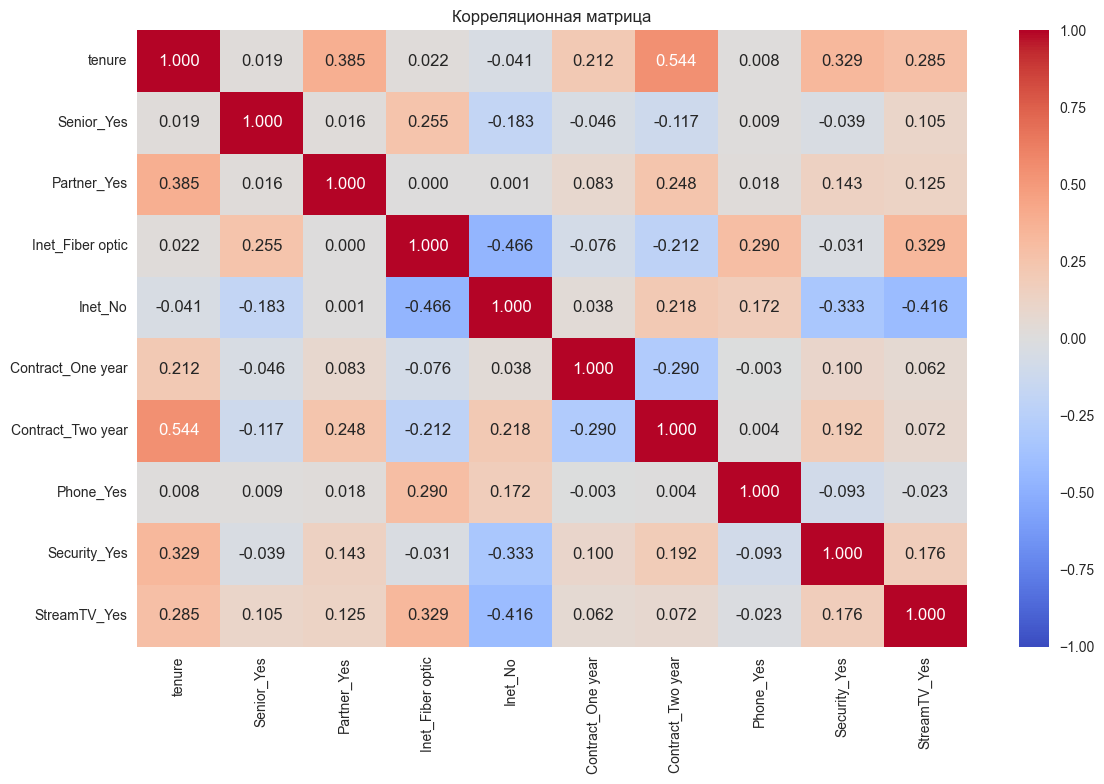

In [29]:
corr = X.corr(method='spearman', numeric_only=True).round(3)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_title('Корреляционная матрица')
plt.tight_layout()
plt.show()


In [30]:
y = df_reg['MonthlyCharges']
X_const = sm.add_constant(X)
model_ols = sm.OLS(y, X_const).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         MonthlyCharges   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.621e+04
Date:                Sun, 01 Mar 2026   Prob (F-statistic):               0.00
Time:                        19:59:04   Log-Likelihood:                -22769.
No. Observations:                7043   AIC:                         4.556e+04
Df Residuals:                    7032   BIC:                         4.564e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                28.3963      0.26

### Модель со стандартизированными коэффицентами (бета-коэффициентами)

In [31]:
X_std = pd.DataFrame(zscore(X), columns=X.columns, index=X.index)
X_std_const = sm.add_constant(X_std)
model_std = sm.OLS(zscore(y), X_std_const).fit()
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.621e+04
Date:                Sun, 01 Mar 2026   Prob (F-statistic):               0.00
Time:                        19:59:04   Log-Likelihood:                 1205.9
No. Observations:                7043   AIC:                            -2390.
Df Residuals:                    7032   BIC:                            -2314.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.158e-17      0.00

R-squared = 0.958: Модель объясняет 95.8% вариации ежемесячных платежей.\
Adj. R-squared = 0.958: Скорректированный R-квадрат подтверждает высокое качество модели.\
F-statistic	= 0: Модель статистически значима.


In [32]:
true_values = y
predicted_values = model_ols.fittedvalues
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)

mae, mse, rmse

(4.927017689689697, 37.63533743350851, np.float64(6.134764659993773))

В среднем прогноз модели отличается от реальных значений на 4.93, типичная ошибка (RMSE) составляет 6.13.

In [33]:
print('Статистически значимые параметры модели: ')
model_ols.pvalues[model_ols.pvalues < 0.05].index.values

Статистически значимые параметры модели: 


<StringArray>
[            'const',            'tenure',  'Inet_Fiber optic',
           'Inet_No', 'Contract_One year', 'Contract_Two year',
         'Phone_Yes',      'Security_Yes',      'StreamTV_Yes']
Length: 9, dtype: str

In [34]:
print('Статистически не значимые параметры модели: ')
model_ols.pvalues[model_ols.pvalues >= 0.05].index.values

Статистически не значимые параметры модели: 


<StringArray>
['Senior_Yes', 'Partner_Yes']
Length: 2, dtype: str

### Сравнение по силе влияния на MonthlyCharges

- **tenure**: При увеличении срока обслуживания на один месяц, ежемесячный платёж увеличивается в среднем на **\$0.11**, что является довольно незначительным увеличением в долгосрочной перспективе.
- **Inet_Fiber optic**: Клиенты с оптоволоконным интернетом в среднем платят на **\$26.26 больше**, чем клиенты с базовым DSL-интернетом. Это самый значительный фактор, увеличивающий стоимость.
- **Inet_No**: Клиенты без подключения к интернету в среднем платят на **\$34.41 меньше**, чем клиенты с DSL. Это показывает, что DSL-интернет сам по себе является базовой и довольно дорогой услугой.
- **Phone_Yes**: Наличие телефонной связи увеличивает ежемесячный платёж в среднем на **\$21.96**, что делает эту услугу второй по силе влияния на итоговую сумму.
- **StreamTV_Yes**: Подключение потокового телевидения увеличивает платёж в среднем на **\$15.44**, что также вносит существенный вклад в итоговый счёт.
- **Security_Yes**: Услуга онлайн-безопасности увеличивает платёж в среднем на **\$5.88**.
- **Contract_Two year**: Клиенты с двухлетним контрактом в среднем платят на **\$2.78 больше**, чем клиенты с помесячной оплатой.
- **Contract_One year**: Клиенты с годовым контрактом в среднем платят на **\$1.84 больше**, чем клиенты с помесячной оплатой.
- **Senior_Yes**: Статус пенсионера связан с увеличением платежа в среднем на **\$0.24**, однако в рамках данной модели это влияние **статистически незначимо**.
- **Partner_Yes**: Наличие у клиента партнёра связано с увеличением платежа в среднем на **\$0.15**, но это влияние также **статистически незначимо**.


Среди всех признаков, наибольшее влияние на итоговый счёт оказывает **тип интернет-подключения** и **наличие телефона**. Оптоволоконный интернет (Inet_Fiber optic) и телефонная связь (Phone_Yes) являются самыми дорогими дополнительными услугами. С другой стороны, отсутствие интернета (Inet_No) приводит к самому большому снижению стоимости. Такие услуги, как стриминговое ТВ и онлайн-безопасность, также заметно увеличивают счёт, но в меньшей степени. Интересно, что долгосрочные контракты не удешевляют, а немного увеличивают ежемесячную плату по сравнению с помесячной оплатой.

### Проверка мультиколлинеарности (VIF)

In [35]:
vifs = np.array([vif(model_ols.model.exog, i) for i in range(model_ols.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model_ols.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
1,1.096901,Senior_Yes
2,1.174890,Partner_Yes
7,1.266556,Phone_Yes
9,1.377029,StreamTV_Yes
8,1.378775,Security_Yes
5,1.550160,Contract_One year
3,1.815425,Inet_Fiber optic
4,2.036922,Inet_No
0,2.295691,tenure
6,2.432951,Contract_Two year


Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.


### Диагностика остатков

P-value: 0.100


<Axes: ylabel='Density'>

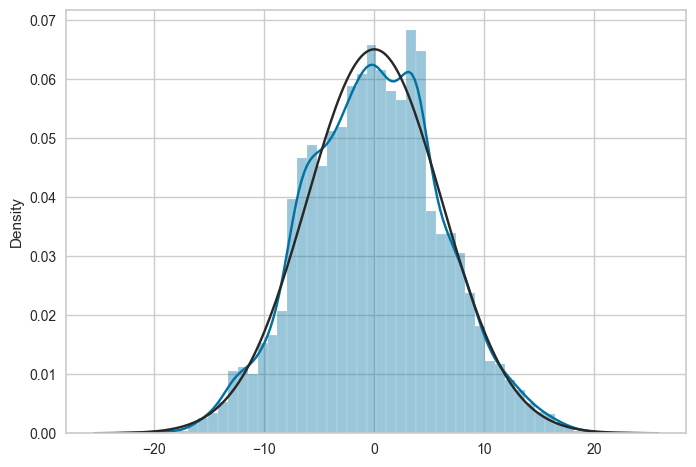

In [36]:
p = stats.kstest(model_ols.resid, 'norm', args=(model_ols.resid.mean(), model_ols.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))
sns.distplot(model_ols.resid, fit=stats.norm)

Нулевая гипотеза H0: остатки распределены нормально.\
p > 0.05 => нулевая гипотеза не отвергается => остатки распределены нормально

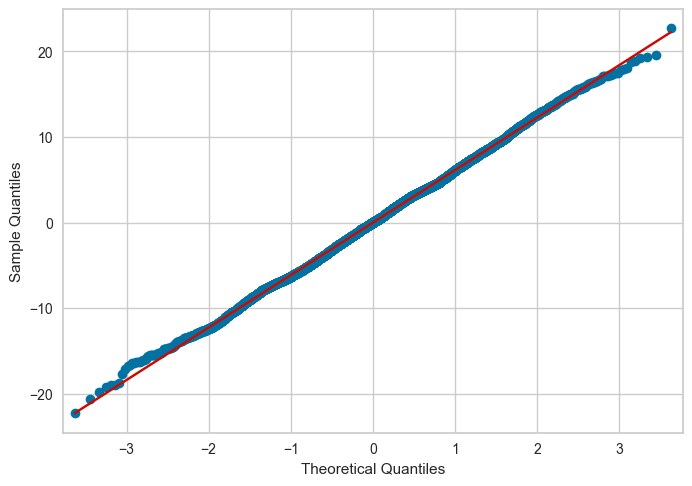

In [37]:
sm.qqplot(model_ols.resid, line='s')
plt.show()


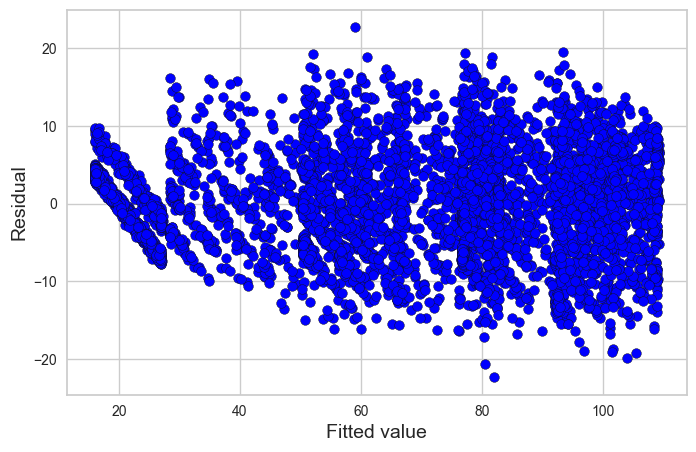

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(x=model_ols.fittedvalues, y=model_ols.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

Ширина облака остатков немного меняется, что может говорить о небольшой гетероскедастичности

In [39]:
influence = model_ols.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_tenure,dfb_Senior_Yes,dfb_Partner_Yes,dfb_Inet_Fiber optic,dfb_Inet_No,dfb_Contract_One year,dfb_Contract_Two year,dfb_Phone_Yes,dfb_Security_Yes,dfb_StreamTV_Yes,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.007822,-0.002303,-0.001143,0.004022,0.000092,-0.001207,-0.000389,0.000131,-0.006289,-0.001612,-0.001569,0.000008,0.194377,0.002266,0.009264,0.194363,0.009264
1,0.000162,0.001792,0.000698,0.010651,0.008620,0.010141,-0.016446,-0.002443,-0.009092,-0.010818,0.009455,0.000096,-0.810624,0.001597,-0.032415,-0.810605,-0.032415
2,-0.001778,0.003997,0.000738,0.002837,0.005480,0.003188,0.002411,0.001313,-0.004973,-0.008802,0.002276,0.000022,-0.425522,0.001336,-0.015566,-0.425497,-0.015565
3,0.005721,0.000933,-0.000610,-0.002563,0.001321,0.000387,0.003154,-0.000212,-0.006076,0.002604,-0.002498,0.000008,0.178372,0.002655,0.009204,0.178359,0.009203
4,-0.010072,0.009024,0.008358,0.006029,-0.013696,0.006707,-0.002313,-0.006604,0.000260,0.004213,0.011909,0.000078,-1.000851,0.000853,-0.029244,-1.000851,-0.029244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.009424,-0.026608,-0.001281,0.018663,-0.020214,-0.006778,0.027946,0.005073,0.015839,0.020199,0.023930,0.000332,1.372716,0.001932,0.060401,1.372803,0.060405
7039,-0.001073,0.002689,-0.001759,0.001043,0.001169,-0.000445,0.002062,-0.001390,0.000016,-0.002570,0.000979,0.000004,0.164868,0.001605,0.006610,0.164857,0.006609
7040,-0.033332,0.009128,0.004710,-0.018120,-0.005231,-0.006686,0.008387,0.007675,0.033588,-0.021331,0.008098,0.000225,-0.989379,0.002522,-0.049745,-0.989377,-0.049745
7041,-0.001376,0.008134,-0.012355,-0.009329,-0.004157,0.002722,-0.001764,-0.003914,-0.000399,0.001548,0.006454,0.000038,-0.498107,0.001700,-0.020557,-0.498081,-0.020556


In [40]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()

Series([], Name: dffits, dtype: float64)

In [41]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values().count()


np.int64(13)

Обнаружено 13 выбросов с \|difits\| > 3 - это не сильно значащие выбросы. выбросов с \|difits\| > 3 обнаружено не было

## Пункт 13. Модель бинарной логистической регрессии

**Зависимая переменная:** Churn_flag (1 = ушёл, 0 = остался).

**Предикторы:** tenure, MonthlyCharges, SeniorCitizen (дамми), InternetService (дамми), Contract (дамми), PaperlessBilling (дамми), PaymentMethod (дамми).

In [42]:
billing_d = pd.get_dummies(df_reg['PaperlessBilling'], prefix='Billing', dtype=int)
payment_d = pd.get_dummies(df_reg['PaymentMethod'], prefix='Pay', dtype=int)
df_reg = pd.concat([df_reg, billing_d, payment_d], axis=1)

X_log_cols = ['tenure', 'MonthlyCharges', 'Senior_Yes',
              'Inet_Fiber optic', 'Inet_No',
              'Contract_One year', 'Contract_Two year',
              'Billing_Yes',
              'Pay_Electronic check', 'Pay_Mailed check', 'Pay_Credit card (automatic)']

X_log = df_reg[X_log_cols]
X_log

,tenure,MonthlyCharges,Senior_Yes,Inet_Fiber optic,Inet_No,Contract_One year,Contract_Two year,Billing_Yes,Pay_Electronic check,Pay_Mailed check,Pay_Credit card (automatic)
0,1,29.85,0,0,0,0,0,1,1,0,0
1,34,56.95,0,0,0,1,0,0,0,1,0
2,2,53.85,0,0,0,0,0,1,0,1,0
3,45,42.30,0,0,0,1,0,0,0,0,0
4,2,70.70,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,0,0,0,1,0,1,0,1,0
7039,72,103.20,0,1,0,1,0,1,0,0,1
7040,11,29.60,0,0,0,0,0,1,1,0,0
7041,4,74.40,1,1,0,0,0,1,0,1,0


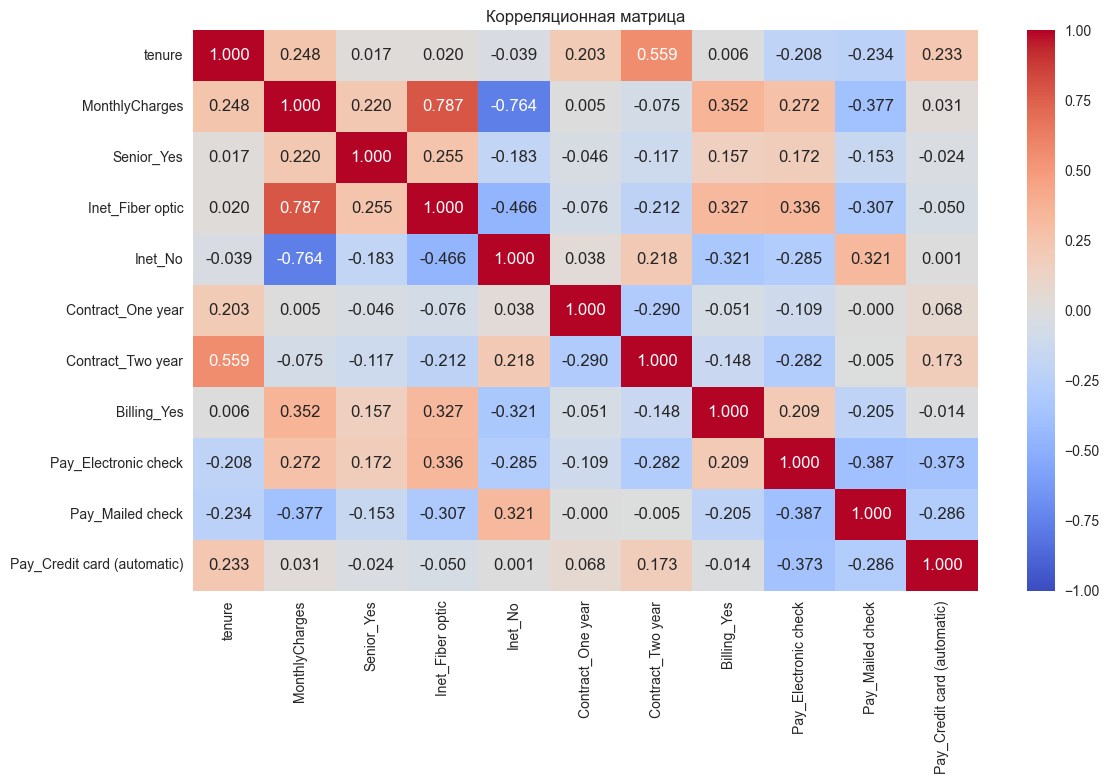

In [43]:
corr = X_log.corr(method='pearson', numeric_only=True).round(3)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_title('Корреляционная матрица')
plt.tight_layout()
plt.show()


Выявлена мультиколлиниарность между (Inet_Fiber optic, MonthlyCharges)=0.787, (Inet_no, MonthlyCharges)=-0.764.\
Уберем переменную MonthlyCharges

In [44]:
X_log = X_log.drop(columns=['MonthlyCharges'])

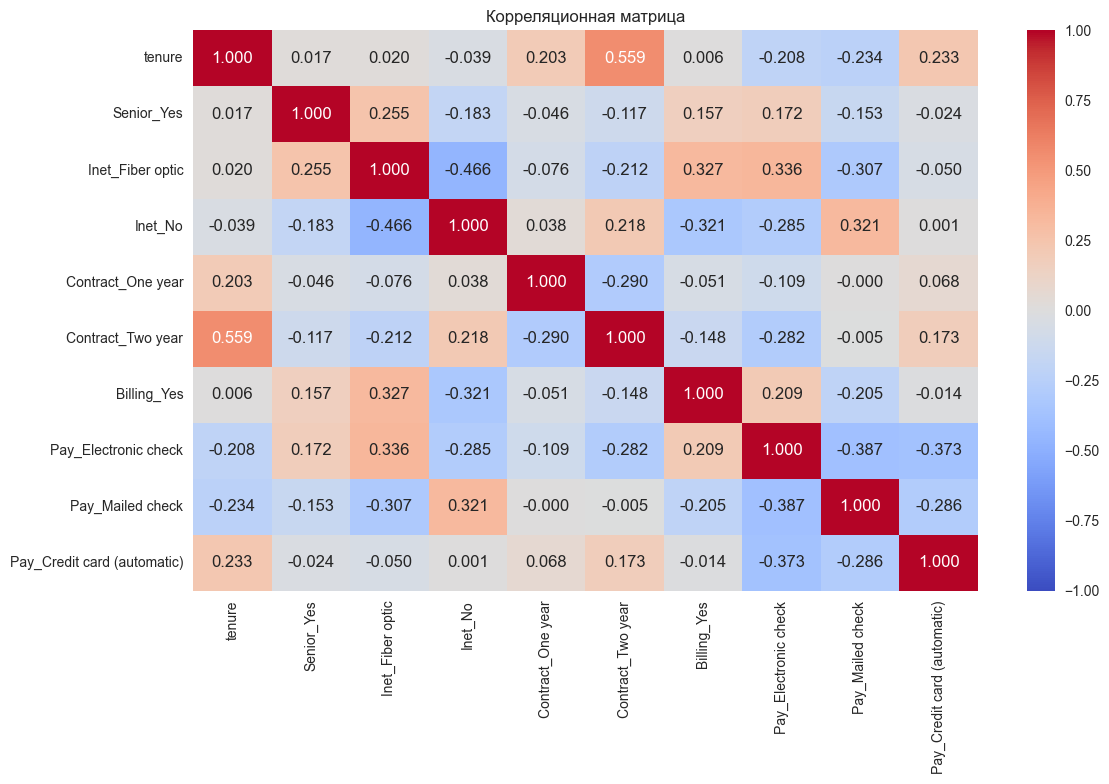

In [45]:
corr = X_log.corr(method='pearson', numeric_only=True).round(3)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_title('Корреляционная матрица')
plt.tight_layout()
plt.show()


In [46]:
y_log = df_reg['Churn_flag']
X_log_const = sm.add_constant(X_log)
model_logit = sm.Logit(y_log, X_log_const).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.423341
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             Churn_flag   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7032
Method:                           MLE   Df Model:                           10
Date:                Sun, 01 Mar 2026   Pseudo R-squ.:                  0.2683
Time:                        19:59:13   Log-Likelihood:                -2981.6
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.7272      0.110     -6.596      0.000   

In [47]:
print('R^2 = {:f}'.format(model_logit.prsquared))
print('Model significance = {:f}'.format(model_logit.llr_pvalue))

R^2 = 0.268334
Model significance = 0.000000


In [48]:
f'Статистически значимые предикторы: {model_logit.pvalues[model_logit.pvalues < 0.05].index.values}'

"Статистически значимые предикторы: <StringArray>\n[               'const',               'tenure',           'Senior_Yes',\n     'Inet_Fiber optic',              'Inet_No',    'Contract_One year',\n    'Contract_Two year',          'Billing_Yes', 'Pay_Electronic check']\nLength: 9, dtype: str"

In [49]:
f'Статистически не значимые предикторы: {model_logit.pvalues[model_logit.pvalues > 0.05].index.values}'

"Статистически не значимые предикторы: <StringArray>\n['Pay_Mailed check', 'Pay_Credit card (automatic)']\nLength: 2, dtype: str"

### Точность предсказаний

In [50]:
predicted_probs = model_logit.predict(X_log_const)
predicted_class = (predicted_probs >= 0.5).astype(int)

cm = confusion_matrix(y_log, predicted_class)
cm_df = pd.DataFrame(cm, index=['Факт: Остался', 'Факт: Ушёл'],
                     columns=['Предсказано: Остался', 'Предсказано: Ушёл'])
print('Матрица ошибок:')
print(cm_df)
print()

accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print(f'Точность (процент верно предсказанных событий): {accuracy:.3f}')

Матрица ошибок:
               Предсказано: Остался  Предсказано: Ушёл
Факт: Остался                  4646                528
Факт: Ушёл                      893                976

Точность (процент верно предсказанных событий): 0.798


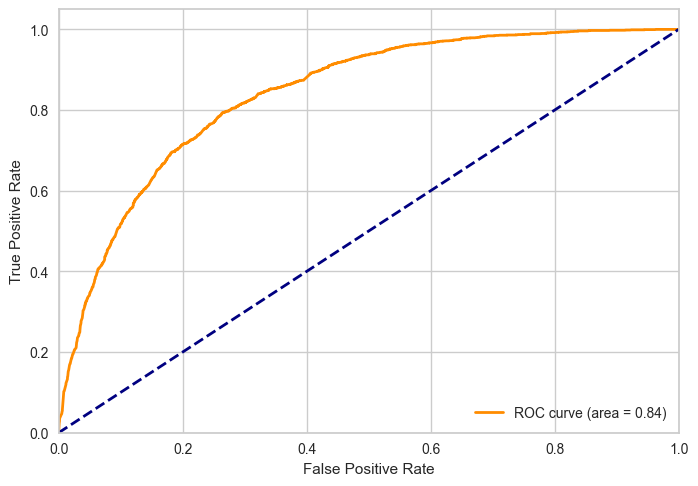

Area under ROC curve: 0.839


In [51]:
fpr, tpr, _ = roc_curve(df['Churn_flag'], model_logit.predict())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print(f'Area under ROC curve: {roc_auc:.3f}')

P-value: 0.000


<Axes: ylabel='Density'>

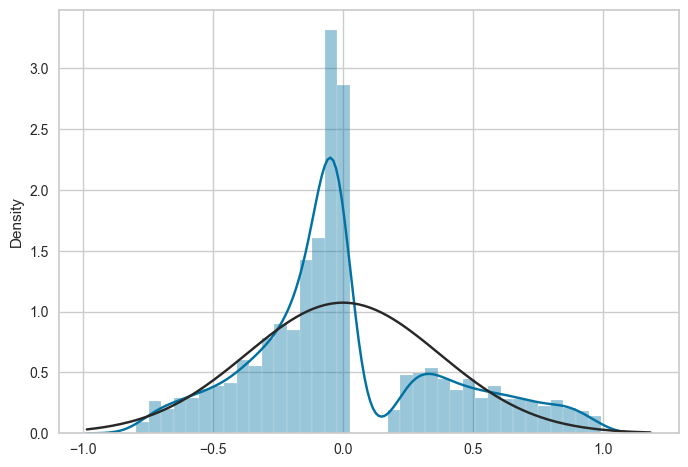

In [52]:
p = stats.kstest(model_logit.resid_generalized, 'norm', args=(model_logit.resid_generalized.mean(), model_logit.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))
sns.distplot(model_logit.resid_generalized, fit=stats.norm)

По результату теста Колмогорова-Смирнова значение p-value = 0.000 < 0.005, поэтому нулевая гипотеза отклоняется, и получается что распределение остатков статистически значимо отличанется от нормального.

In [53]:
vifs = np.array([vif(model_logit.model.exog, i) for i in range(model_logit.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model_logit.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
1,1.100475,Senior_Yes
6,1.191661,Billing_Yes
3,1.446370,Inet_No
2,1.495979,Inet_Fiber optic
4,1.545943,Contract_One year
9,1.558420,Pay_Credit card (automatic)
8,1.834055,Pay_Mailed check
7,1.948308,Pay_Electronic check
0,2.233057,tenure
5,2.429270,Contract_Two year


Значение VIF ниже 10. Это показывает что мультиколлинеарность отсутсвует между предикатами.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=0)

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_train)
clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
print("Train Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

Train Result:
Accuracy Score: 80.09%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.843486     0.651479  0.800852     0.747483      0.792332
recall        0.894508     0.542971  0.800852     0.718739      0.800852
f1-score      0.868248     0.592297  0.800852     0.730272      0.794730
support    4133.000000  1501.000000  0.800852  5634.000000   5634.000000
_______________________________________________
Confusion Matrix: 
 [[3697  436]
 [ 686  815]]



In [56]:
pred = lr.predict(X_test)
clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))

print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Test Result:
Accuracy Score: 79.21%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.835727    0.627119  0.792051     0.731423      0.781243
recall        0.894332    0.502717  0.792051     0.698525      0.792051
f1-score      0.864037    0.558069  0.792051     0.711053      0.784125
support    1041.000000  368.000000  0.792051  1409.000000   1409.000000
_______________________________________________
Confusion Matrix: 
 [[931 110]
 [183 185]]



По результатам оценки видно, что модель показывает стабильные результаты как на обучающей выборке, так и на тестовой. Разница в точности составляет всего 80.09% - 79.21% = 0.88%. Это значит, что модель хорошо обобщает данные и не имеет признаков переобучения.

Из матриц ошибок видно, что существует заметный перекос в сторону ложноотрицательных (FN) ответов по сравнению с ложноположительными (FP) как на тренировочной, так и на тестовой выборках: (686 против 436) и (183 против 110) соответственно. Это означает, что модель чаще пропускает уходящих клиентов (ошибочно предсказывая, что они останутся), чем ложно обвиняет лояльных клиентов в желании уйти. Мы "недолавливаем" около половины реального оттока (Recall для класса 1 равен ~50%).


Модель логистической регрессии статистически значима (LLR p-value = 0.000).

Существенно влияют на вероятность оттока: срок обслуживания, пенсионный статус, тип интернета (оптоволокно или его отсутствие), тип контракта, безбумажное выставление счетов и оплата электронным чеком. Способы оплаты почтовым чеком или кредитной картой значимыми не оказались.

Предсказательная сила хорошая: точность (accuracy) составляет примерно 0.798 (около 80% верных предсказаний). При этом модель лучше справляется с определением лояльных клиентов, чем тех, кто планирует уйти (976 верно предсказанных уходов против 893 пропущенных).

## Интерпретация статистически значимых коэффициентов логистической регрессии

- **tenure** - Каждый дополнительный месяц обслуживания клиента снижает шансы его ухода примерно на 3.1%. Это подтверждает логичное правило: чем дольше клиент с компанией, тем он лояльнее.
- **Senior_Yes** - Статус пенсионера увеличивает шансы оттока примерно на 37.6% по сравнению с более молодыми клиентами. Пожилые пользователи в этой выборке чаще отказываются от услуг.
- **Inet_Fiber optic** - Наличие оптоволоконного интернета увеличивает шансы ухода на 168.9% (почти в 2.7 раза) по сравнению с базовым DSL-подключением. Это мощнейший драйвер оттока. Такая ситуация может указывать на две основные проблемы: либо у конкурентов дешевле, либо существуют серьезные проблемы с качеством и стабильностью самого оптоволоконного соединения, из-за чего клиенты уходят искать лучший сервис.
- **Inet_No** - Отсутствие интернета снижает шансы оттока примерно на 56.1% по сравнению с клиентами на DSL. Пользователи только базовых услуг (например, только телефон) являются одними из самых стабильных.
- **Contract_One year** - Наличие контракта на один год снижает шансы ухода примерно на 51.4% по сравнению с помесячной оплатой (Month-to-month).
- **Contract_Two year** - Наличие двухлетнего контракта снижает шансы ухода на 77.4% по сравнению с помесячной оплатой. Долгосрочные контракты являются самым эффективным инструментом удержания.
- **Billing_Yes (PaperlessBilling)** - Использование безбумажного выставления счетов увеличивает шансы оттока на 50.1%. Цифровые пользователи более мобильны и чаще переходят к конкурентам.
- **Pay_Electronic check** - Использование электронного чека для оплаты увеличивает шансы ухода на 50%. Это самый рискованный способ оплаты.

Переменные **Pay_Mailed check** и **Pay_Credit card (automatic)** имеют p-values выше 0.05 (0.703 и 0.449 соответственно) и являются статистически незначимыми.
Это означает, что по данным выборки оплата бумажным чеком по почте или автоматическое списание с кредитной карты не оказывают подтверждённого влияния на вероятность оттока клиента (по сравнению с базовым методом оплаты - банковским переводом).

## Пункт 14. Кластерный анализ

<Axes: >

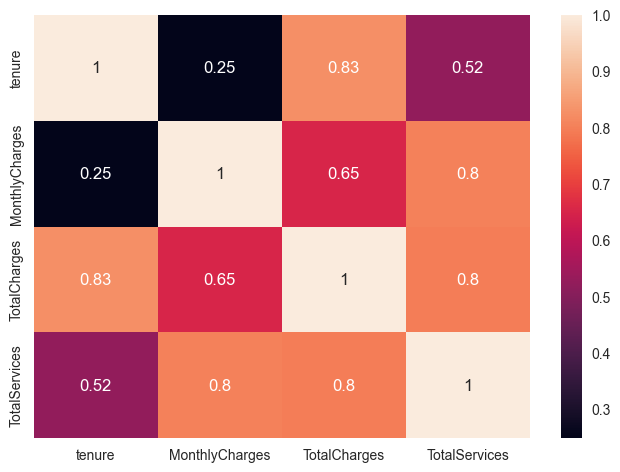

In [57]:
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']

X_clust = df[cluster_features]
sns.heatmap(X_clust.corr(numeric_only=True), annot=True)

В нашем датасете всего 4 метрических признака. Поэтому хоть и корелляция между TotalCharges и tenure большая, не будем ее убирать. а вот TotalServices уберем, так как корелляция с другими данными большая

In [58]:
cluster_features.remove('TotalCharges')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

print(f'Признаки для кластеризации: {cluster_features}')
print(f'Данные стандартизированы: mean = 0, std = 1')

Признаки для кластеризации: ['tenure', 'MonthlyCharges', 'TotalServices']
Данные стандартизированы: mean = 0, std = 1


### Дендрограмма

In [59]:
X_scaled

array([[-1.27744458, -1.16032292, -1.14599684],
       [ 0.06632742, -0.25962894, -0.17601057],
       [-1.23672422, -0.36266036, -0.17601057],
       ...,
       [-0.87024095, -1.1686319 , -1.14599684],
       [-1.15528349,  0.32033821, -0.66100371],
       [ 1.36937906,  1.35896134,  1.27896883]], shape=(7043, 3))

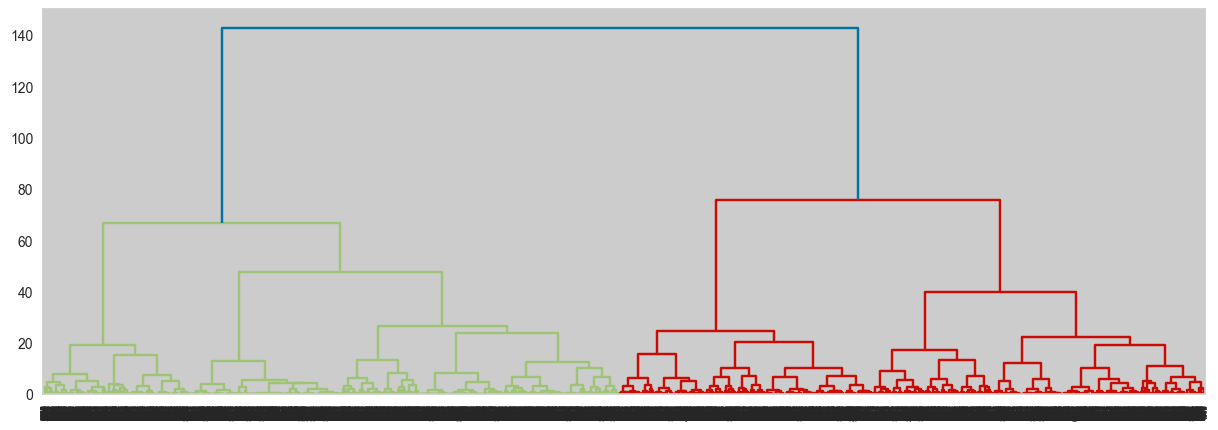

In [60]:
plt.figure(figsize=(15, 5))
dn = dendrogram(linkage(X_scaled, 'ward'))

### Определение оптимального числа кластеров

In [61]:
Z = linkage(X_scaled, method='ward', metric='euclidean')
for k in range (2, 20):
    labels = fcluster(Z, t=k, criterion='maxclust')
    print('Число кластеров: {}, индекс {}'.format(k, calinski_harabasz_score(X_scaled, labels)))

Число кластеров: 2, индекс 6585.541391625045
Число кластеров: 3, индекс 5701.989115502083
Число кластеров: 4, индекс 6134.805901764885
Число кластеров: 5, индекс 6122.444628372611
Число кластеров: 6, индекс 6166.996016560243
Число кластеров: 7, индекс 5756.877680379822
Число кластеров: 8, индекс 5492.25492835402
Число кластеров: 9, индекс 5356.294515494268
Число кластеров: 10, индекс 5273.919789200005
Число кластеров: 11, индекс 5190.5946920388715
Число кластеров: 12, индекс 5146.950352347061
Число кластеров: 13, индекс 5175.183979012229
Число кластеров: 14, индекс 5165.549011299766
Число кластеров: 15, индекс 5143.380846635937
Число кластеров: 16, индекс 5144.115422850854
Число кластеров: 17, индекс 5102.656075975049
Число кластеров: 18, индекс 5086.95368340908
Число кластеров: 19, индекс 5100.495836371308


Смотрим на индекс Калинского-Харабаша, который показывает наилучшее значение при k=16

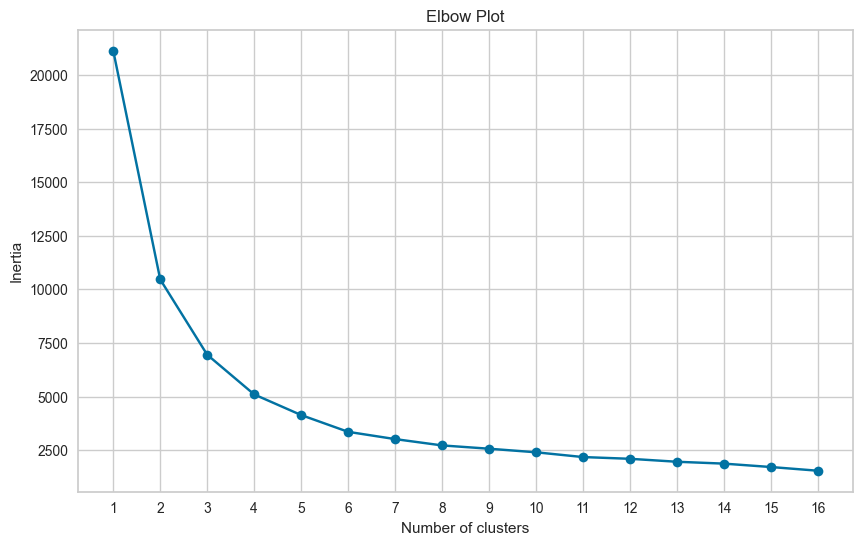

In [62]:
inertia = []
k_range = range(1, 17)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

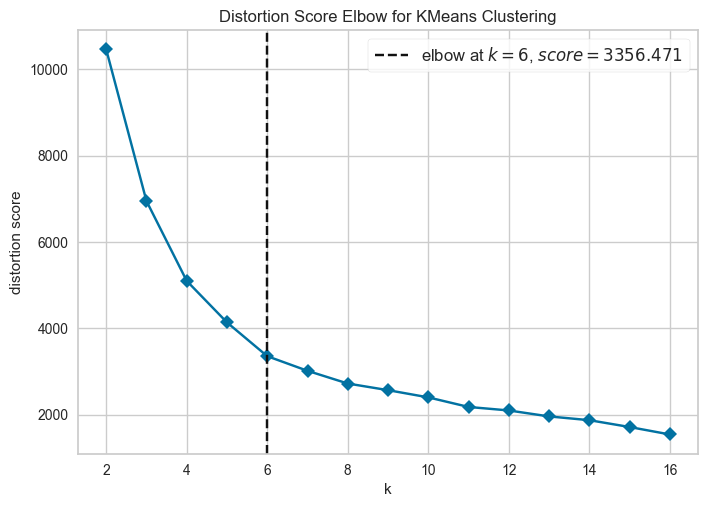

In [63]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,17), timings=False, force_model=True)

visualizer.fit(X_scaled)
visualizer.show()
plt.show()

Видно, что уже после 5 кластеров изгиб становится менее выраженным. Да и индекс Калинского-Харабаша после 5 продолжает восрастать медленее

### Кластеризация K-Means (k = 5)

In [64]:
k_opt = 5
km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

print(f'Распределение по кластерам:')
print(df['Cluster'].value_counts().sort_index())

Распределение по кластерам:
Cluster
0    1444
1    1310
2    1571
3    1669
4    1049
Name: count, dtype: int64


In [65]:
cluster_desc = df.groupby('Cluster')[['tenure', 'MonthlyCharges', 'TotalCharges']].agg(['mean', 'median', 'std']).round(2)
print(cluster_desc)

        tenure               MonthlyCharges               TotalCharges  \
          mean median    std           mean median    std         mean   
Cluster                                                                  
0        25.79   26.0  13.56          86.56  89.65  13.11      2183.74   
1        10.98    8.0   9.90          25.63  20.45   8.86       264.83   
2         9.97    7.0   9.28          67.88  70.30  12.74       658.85   
3        61.68   64.0   9.57          93.54  96.10  15.11      5761.93   
4        55.05   55.0  11.69          33.16  25.05  15.47      1815.27   

                           
          median      std  
Cluster                    
0        2188.02  1149.14  
1         190.25   244.18  
2         484.05   615.90  
3        5705.05  1292.75  
4        1498.35   923.83  


In [66]:
print('\nДоля оттока по кластерам:')
print(df.groupby('Cluster')['Churn_flag'].mean().round(3))


Доля оттока по кластерам:
Cluster
0    0.389
1    0.214
2    0.482
3    0.132
4    0.049
Name: Churn_flag, dtype: float64


In [67]:
print('\nРаспределение типов контрактов по кластерам:')
print(pd.crosstab(df['Cluster'], df['Contract'], normalize='index').round(3) * 100)


Распределение типов контрактов по кластерам:
Contract  Month-to-month  One year  Two year
Cluster                                     
0                   74.0      20.6       5.5
1                   67.6      19.5      13.0
2                   92.2       6.6       1.3
3                   18.2      32.2      49.6
4                   16.2      26.8      57.0


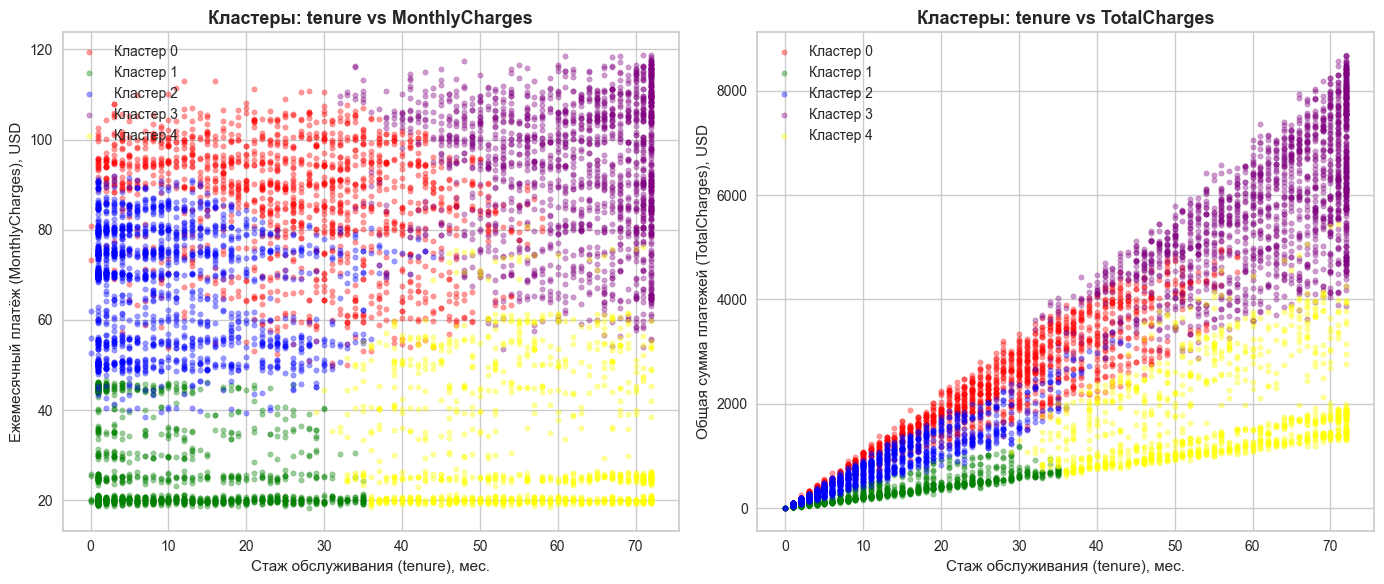

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['red', 'green', 'blue', 'purple', 'yellow']
for cl in range(k_opt):
    mask = df['Cluster'] == cl
    axes[0].scatter(df.loc[mask, 'tenure'], df.loc[mask, 'MonthlyCharges'],
                    alpha=0.4, label=f'Кластер {cl}', color=colors[cl], s=15)
axes[0].set_xlabel('Стаж обслуживания (tenure), мес.', fontsize=11)
axes[0].set_ylabel('Ежемесячный платёж (MonthlyCharges), USD', fontsize=11)
axes[0].set_title('Кластеры: tenure vs MonthlyCharges', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)

for cl in range(k_opt):
    mask = df['Cluster'] == cl
    axes[1].scatter(df.loc[mask, 'tenure'], df.loc[mask, 'TotalCharges'],
                    alpha=0.4, label=f'Кластер {cl}', color=colors[cl], s=15)
axes[1].set_xlabel('Стаж обслуживания (tenure), мес.', fontsize=11)
axes[1].set_ylabel('Общая сумма платежей (TotalCharges), USD', fontsize=11)
axes[1].set_title('Кластеры: tenure vs TotalCharges', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

**Описание кластеров:**

| Кластер | Название                                 | Характеристика                                                                                                                                                                                                                                              |
| :--- |:-----------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **0** | **«Средний стаж, высокий чек»**          | Средний стаж 26 месяцев, высокие ежемесячные платежи. Преобладает помесячная оплата (74%). Уровень оттока высокий (38.9%). Это клиенты, которые уже приносят стабильный доход, но находятся в зоне риска из-за отсутствия долгосрочных обязательств.        |
| **1** | **«Новички с базовыми услугами»**        | Короткий стаж 11 месяцев, самые низкие ежемесячные платежи, малая общая сумма оплат. В основном на помесячном контракте (68%). Уровень оттока умеренный (21.4%). Вероятно, это пользователи только телефона (без интернета).                                |
| **2** | **«Новички в зоне максимального риска»** | Самый короткий стаж 10 месяцев, средние/выше среднего платежи. Почти исключительно помесячная оплата (92.2%). **Самый высокий уровень оттока (48.2%)**. Это главная проблемная группа: они быстро приходят и почти в половине случаев так же быстро уходят. |
| **3** | **«VIP-постоянники»**                    | Самый большой стаж 62 месяцев, самые высокие ежемесячные и суммарные платежи. Преимущественно долгосрочные контракты (81.8% на год или два). Низкий уровень оттока (13.2%). Это самая ценная и стабильная база компании.                                    |
| **4** | **«Лояльные эконом-клиенты»**            | Большой стаж 55 месяцев, низкие ежемесячные платежи. Большинство на двухлетних или годовых контрактах (83.8%). **Самый низкий уровень оттока (4.9%)**. Эти клиенты платят мало, но они максимально надежны и стабильны.                                     |


**Вывод:**

Кластерный анализ позволил выделить **5 чётких сегментов клиентов**, подтверждая и расширяя выводы логистической регрессии.

Наибольший риск оттока сконцентрирован в кластере 2 («Новички в зоне максимального риска» - отток 48.2%). Это клиенты с небольшим стажем, средними чеками и подавляющим большинством помесячных контрактов. Их удержание должно стать главным приоритетом (например, через предложение скидок за переход на годовой контракт).

С другой стороны, кластеры 3 и 4 демонстрируют отличную лояльность (отток 13.2% и 4.9% соответственно). Их объединяет высокий стаж (более 4.5 лет) и наличие долгосрочных контрактов, при этом размер ежемесячного платежа для них уже не играет решающей роли в вопросе ухода. Бизнесу необходимо разрабатывать стратегии плавного перевода клиентов из «помесячных» кластеров (0, 1, 2) в «контрактные» (3, 4).


## Пункт 15. Выводы по исследовательским гипотезам

| № | Гипотеза                                  | Результат          | Обоснование                                                                                                                                                                                         |
|---|-------------------------------------------|--------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| H1 | Помесячный контракт -> выше отток          | ✅ **Подтверждена** | x^2-тест значим (p < 0.001). Доля оттока: month-to-month 43% vs two year 3%                                                                                                                         |
| H2 | Выше платёж -> выше отток                  | ✅ **Подтверждена** | Корреляция Спирмена MonthlyCharges–Churn_flag = 0.2; ушедшие платят в среднем больше                                                                                                                |
| H3 | Пожилые клиенты чаще уходят               | ✅ **Подтверждена** | Коэффициент Senior_Yes в модели положительный и значимый                                                                                                                                            |
| H4 | Без интернета -> ниже отток                | ✅ **Подтверждена** | Коэффициент Inet_No в логистической регрессии имеет сильный отрицательный вклад (-0.82) и статистически значим (p < 0.001)                                                                          |
| H5 | DSL -> выше отток чем Fiber optic          | ❌**Опровергнута**  | x^2-тест значим. Доля оттока: Fiber optic 42% vs DSL 19%                                                                                                                                            |
| H6 | Выше общая сумма -> ниже отток            | ✅ **Подтверждена** | Наблюдается отрицательная корреляция. Клиенты из кластеров 3 и 4 с максимальными TotalCharges имеют самый низкий отток (4.9% - 13.2%).                                                              |
| H7 | tenure отрицательно коррелирует с оттоком | ✅ **Подтверждена** | r_s = −0.35 (Спирмен), коэффициент в модели отрицательный и значимый                                                                                                                                |
| H8 | Безбумажный биллинг -> выше отток          | ✅ **Подтверждена** | Billing_Yes в модели положительный и значимый                                                                                                                                                       |
| H9 | Electronic check -> выше отток             | ✅ **Подтверждена** | x^2-тест значим. Доля оттока Electronic check 45% vs автоматические 16–19%                                                                                                                          |
| H10 | Оплата кредитной картой снижает отток | ❌ **Опровергнута** | В модели логистической регрессии коэффициент признака Pay_Credit card (automatic) оказался статистически незначимым (p-value = 0.449). Данный метод оплаты не оказывает подтвержденного влияния на отток. 

8 из 10 гипотез подтвердились на основе проведенного анализа. Две гипотезы (H5 и H10) были опровергнуты: данные показали, что оптоволоконный интернет генерирует больший отток, чем DSL, а оплата кредитной картой не оказывает статистически значимого влияния на удержание клиентов по сравнению с базовым банковским переводом.

## Пункт 16. Выводы


Цель данного исследования заключалась в выявлении ключевых факторов, влияющих на отток клиентов телекоммуникационной компании.

Доказательствами успешной реализации цели и поставленных задач служат следующие результаты:
1. **Проведен комплексный анализ данных:** Данные были очищены, категориальные переменные преобразованы в фиктивные (dummy-переменные), проведена проверка на мультиколлинеарность (выявлена и устранена проблема дублирующих признаков отсутствия интернета).
2. **Построены модели:** Успешно обучена модель логистической регрессии, обладающая хорошей предсказательной силой (Accuracy ≈ 80%). Модель статистически значима (LLR p-value = 0.000) и позволяет не только прогнозировать отток, но и интерпретировать влияние каждого признака.
3. **Проведена кластеризация:** С помощью алгоритма K-Means клиентская база была разделена на 5 интерпретируемых кластеров. Выявлена конкретная «группа риска» (Кластер 2 с оттоком 48.2%) и «группы лояльности» (Кластеры 3 и 4 с оттоком ниже 13%).
4. **Проверены исследовательские гипотезы:** Сформулировано и статистически протестировано 10 гипотез, что позволило получить объективные (математически обоснованные) ответы на вопросы о поведении клиентов, отвергнув неверные предположения.

### 2. Общие выводы по результатам анализа данных

На основе проведенного анализа можно сформировать четкие профили лояльного и уходящего клиента.

*   **Профиль клиента, склонного к оттоку:** Это, как правило, новый клиент (небольшой tenure), который подключает дорогие услуги (в первую очередь, оптоволоконный интернет). Он не связывает себя долгосрочными обязательствами (выбирает помесячную оплату), предпочитает цифровые каналы взаимодействия (безбумажные счета) и оплачивает услуги вручную электронным чеком.
*   **Профиль лояльного клиента:** Это клиент, который пользуется услугами компании долгое время. Он предпочитает стабильность: заключает контракты на 1 или 2 года. Интересно, что лояльность максимальна как среди пользователей самых базовых и дешевых услуг (только телефон, без интернета), так и среди VIP-клиентов с очень высоким чеком, но длинным стажем.

Главным способом удержания является переключение клиентов с помесячной формы оплаты на долгосрочные контракты.

### 3. Ожидаемые и неожиданные выводы

*   **Срок обслуживания (tenure) и тип контракта:** Ожидаемо, что чем дольше клиент с компанией и чем жестче условия его контракта (1-2 года), тем ниже вероятность ухода.
*   **Влияние цены:** Логично, что более высокий ежемесячный платёж повышает чувствительность клиента и вероятность его ухода к конкурентам (подтверждено регрессией).

** Неожиданные выводы:**
*   **Оптоволокно уходит чаще, чем DSL.** Казалось бы, оптоволоконный интернет - это более современная, быстрая и качественная технология. Ожидалось, что пользователи лучшей технологии будут более лояльны. На деле оказалось наоборот (отток 42% против 19%). Вероятно, технология либо слишком дорого стоит относительно конкурентов, либо компания испытывает технические сбои при предоставлении именно этой услуги.
*   **Оплата электронным чеком генерирует отток.** В цифровую эпоху ожидается, что электронные методы оплаты удобны и повышают лояльность. Однако данные показали, что этот метод сильно увеличивает отток по сравнению с другими. Причина может крыться в том, что в отличие от автоплатежа (где деньги списываются незаметно), ручная оплата электронным чеком заставляет клиента каждый месяц физически расставаться с деньгами, что создает регулярную точку для принятия решения об отказе от услуг.
*   **Пожилые люди уходят чаще.** Традиционно считается, что пожилые люди более консервативны, неохотно меняют провайдеров и привыкают к одному сервису. Однако логистическая регрессия показала, что статус пенсионера увеличивает шансы оттока. Вероятно, эта категория пользователей наиболее чувствительна к повышению тарифов из-за фиксированного дохода.